In [1]:
from pathlib import Path
from time import time
import datetime

import numpy as np
import pandas as pd

from scipy.stats import spearmanr

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
# Global Settings

# Directories
model_dataDir = 'DATA/MODELDATA/'
bench_dataDir = 'DATA/COINHISTDATA/'


# Time
START = 2020
END = 2022


# Helpers
sns.set_style('whitegrid')
np.random.seed(42)
idx = pd.IndexSlice


In [3]:
# Import Data

# Predictions
lr_predictions = pd.read_hdf(f'{model_dataDir}lr_model_predictions.h5', 'lr/predictions')
ridge_predictions = pd.read_hdf(f'{model_dataDir}Ridge_Predictions.h5', 'ridge/predictions')
lasso_predictions = pd.read_hdf(f'{model_dataDir}Lasso_Predictions.h5', 'lasso/predictions')

# Prices
model_mdf = pd.read_csv(model_dataDir + 'ModelData.csv')
model_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
model_mdf['Dates'] = pd.to_datetime(model_mdf['Dates'])
model_mdf.set_index(['Dates', 'Coin'], inplace=True)
prices = model_mdf.loc[:,'Open':'Close']

# Benchmark
bench = pd.read_csv(bench_dataDir + 'bitcoin.csv')
bench.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
bench.set_index('Dates', inplace=True)
bench = bench.loc[:, ['Open']]
#bench = bench.Open
bench = bench.pct_change()
bench = bench.loc[str(START):]
bench.rename(columns = {'Open':'Bench'}, inplace = True)
print(bench.head())


               Bench
Dates               
2020-01-01 -0.004841
2020-01-02 -0.010226
2020-01-03  0.008102
2020-01-04  0.017150
2020-01-05  0.017537


In [5]:
lr_predictions.tail()

actuals  predicted
Coin  Dates                          
zcash 2020-08-03  0.032509   0.004616
      2020-08-04  0.114859   0.005508
      2020-08-05  0.000649  -0.001178
      2020-08-06 -0.015238   0.006421
      2020-08-07  0.011990   0.009187

In [6]:
ridge_predictions.tail()

actuals  predicted    alpha
Coin  Dates                                   
zcash 2020-08-03  0.032509  -0.000501  50000.0
      2020-08-04  0.114859  -0.000565  50000.0
      2020-08-05  0.000649  -0.000853  50000.0
      2020-08-06 -0.015238  -0.000714  50000.0
      2020-08-07  0.011990  -0.000599  50000.0

In [7]:
lasso_predictions.tail()

actuals  predicted  alpha
Coin  Dates                                 
zcash 2020-08-03  0.032509        0.0   10.0
      2020-08-04  0.114859        0.0   10.0
      2020-08-05  0.000649        0.0   10.0
      2020-08-06 -0.015238        0.0   10.0
      2020-08-07  0.011990        0.0   10.0

In [8]:
bench = bench.iloc[::-1]
bench.tail()

,Bench
Dates,
2020-01-05,0.017537
2020-01-04,0.017150
2020-01-03,0.008102
2020-01-02,-0.010226
2020-01-01,-0.004841


In [9]:
def filterdata(mdf,START):
    '''
    :param mdf: A MultiIndex DataFrame
    :param START: A start year as integer
    :return: MultiIndex Dataframe filtered by the above
    '''
    filtered = []
    for coin, new_df in mdf.groupby(level=1):
        new_df['Coin'] = new_df.index.get_level_values('Coin')
        new_df['Dates'] = new_df.index.get_level_values('Dates')
        new_df.set_index(new_df.index.get_level_values('Dates'), inplace=True)
        new_df = new_df.loc[str(START):]
        new_df.set_index(['Dates', 'Coin'], inplace=True)

        #print(new_df)
        filtered.append(new_df)

    mdf = pd.concat(filtered)
    mdf.sort_index(inplace=True)

    return mdf


In [10]:
prices = filterdata(prices,START) 
prices = prices.iloc[::-1]
prices = prices.swaplevel()
prices.tail()

,,Open,High,Low,Close
Coin,Dates,,,,
bitcoin,2020-01-01,7212.799217,7235.438382,7118.483482,7118.483482
binancecoin,2020-01-01,13.789327,13.816538,13.499053,13.499053
basic-attention-token,2020-01-01,0.183047,0.194453,0.183047,0.188258
arweave,2020-01-01,0.807792,0.812910,0.651879,0.661770
algorand,2020-01-01,0.218748,0.222235,0.216208,0.217082


In [39]:
def get_backtest_data(predictions, prices):
    """Combine regression model predictions
        with  OHLCV data"""
    
    best_alpha = predictions.groupby('alpha').apply(lambda x: spearmanr(x.actuals, x.predicted)[0]).idxmax()
    predictions = predictions[predictions.alpha == best_alpha]
    tickers = predictions.index.get_level_values('Coin').unique()
    
    start = predictions.index.get_level_values('Dates').min().strftime('%Y-%m-%d')
    stop = (predictions.index.get_level_values('Dates').max() + pd.DateOffset(1)).strftime('%Y-%m-%d')
    idx = pd.IndexSlice
    #prices = prices.sort_index().loc[idx[tickers, start:stop], :]
    predictions = predictions.loc[predictions.alpha == best_alpha, ['predicted']]

    print(predictions.head())
    print(predictions.tail())

    print('-----------------')
    prices = prices.sort_index()
    print(prices.head())
    
    mdf = predictions.join(prices)

    
    return mdf


data = get_backtest_data(lasso_predictions,prices)
print(data.info())

                     predicted
Coin     Dates                
algorand 2022-01-08  -0.008628
         2022-01-09  -0.013743
         2022-01-10  -0.008373
         2022-01-11  -0.009794
         2022-01-12  -0.019287
                  predicted
Coin  Dates                
zcash 2020-08-03  -0.003316
      2020-08-04  -0.002424
      2020-08-05  -0.009110
      2020-08-06  -0.001510
      2020-08-07   0.001254
-----------------
                         Open      High       Low     Close
Coin     Dates                                             
algorand 2020-01-01  0.218748  0.222235  0.216208  0.217082
         2020-01-02  0.217110  0.223550  0.212620  0.221130
         2020-01-03  0.225794  0.228268  0.223328  0.227190
         2020-01-04  0.228031  0.235819  0.227050  0.235536
         2020-01-05  0.234223  0.237087  0.229622  0.231797
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 29791 entries, ('algorand', Timestamp('2022-01-08 00:00:00')) to ('zcash', Timestamp('2020-08-07 00

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [40]:
#data['predicted'].nan().sum()

In [41]:
data.head(100)

predicted       Open       High        Low  \
Coin             Dates                                                    
algorand         2022-01-08  -0.008628   1.458001   1.458001   1.330172   
                 2022-01-09  -0.013743   1.429196   1.437796   1.385653   
                 2022-01-10  -0.008373   1.411936   1.440960   1.336142   
                 2022-01-11  -0.009794   1.415450   1.461106   1.371479   
                 2022-01-12  -0.019287   1.473883   1.501560   1.441921   
...                                ...        ...        ...        ...   
cosmos           2022-01-12  -0.024192  40.682819  42.113505  39.453661   
                 2022-01-13  -0.022448  39.952802  41.026501  37.698246   
                 2022-01-14  -0.025334  38.446476  40.782052  37.014787   
crypto-com-chain 2022-01-08  -0.002304   0.475535   0.482955   0.443736   
                 2022-01-09  -0.006231   0.465473   0.475755   0.452427   

                                 Close  
Coin             Dates                  
algorand         2022-01-08   1.421041  
                 2022-01-09   1.396139  
                 2022-01-10   1.425014  
                 2022-01-11   1.461106  
                 2022-01-12   1.449939  
...                                ...  
cosmos           2022-01-12  39.778185  
                 2022-01-13  38.180580  
                 2022-01-14  40.170396  
crypto-com-chain 2022-01-08   0.460560  
                 2022-01-09   0.470018  

[100 rows x 5 columns]

In [42]:
#data = data.swaplevel()
data.tail()

predicted       Open        High        Low      Close
Coin  Dates                                                             
zcash 2020-08-03  -0.003316  84.509097   85.004286  82.253969  83.176376
      2020-08-04  -0.002424  83.223139   86.492926  81.376570  85.880364
      2020-08-05  -0.009110  86.186518   97.661780  86.016126  95.744515
      2020-08-06  -0.001510  94.690114  101.316163  93.608971  95.806635
      2020-08-07   0.001254  95.875042   96.794188  90.509643  94.346697

In [43]:
# Daily returns for all the coins in the dataset for the target time period
daily_returns = data.Open.unstack('Coin').sort_index().pct_change()
daily_returns.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 532 entries, 2020-08-01 to 2022-01-14
Columns: 56 entries, algorand to zcash
dtypes: float64(56)
memory usage: 236.9 KB


In [45]:
# Compute forward returns
fwd_returns = daily_returns.shift(-1)
fwd_returns.tail()

Coin,algorand,arweave,basic-attention-token,binancecoin,bitcoin,bitcoin-cash,bitcoin-cash-sv,bittorrent-old,blockstack,cardano,...,ripple,stellar,terra-luna,tezos,theta-fuel,theta-token,thorchain,tron,vechain,zcash
Dates,,,,,,,,,,,,,,,,,,,,,
2022-01-10,0.002489,-0.087373,-0.014639,-0.026952,-0.001062,-0.026788,-0.019670,-0.028754,-0.064754,-0.013432,...,-0.010429,-0.035721,-0.014720,-0.042968,-0.021592,-0.036007,-0.057254,-0.041211,-0.044570,-0.010028
2022-01-11,0.041282,0.039454,0.040151,0.058507,0.006762,0.009606,0.021411,0.035565,0.066226,0.044364,...,0.026736,0.058377,0.011006,0.036675,0.019894,0.048856,0.069825,0.022545,0.052434,-0.003883
2022-01-12,-0.010347,0.067951,0.023523,0.047047,0.024422,0.036881,0.023753,0.014107,0.026438,0.081009,...,0.026569,0.059947,0.105173,0.024902,0.010345,0.011986,0.100005,0.031197,0.045236,0.021914
2022-01-13,-0.049142,-0.036271,-0.034170,0.006722,-0.022079,0.004048,0.000023,-0.031307,-0.014063,-0.039519,...,-0.021161,-0.045459,-0.013777,-0.025365,-0.001342,-0.042170,-0.069115,-0.009678,-0.034372,-0.028606
2022-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# Isolate the predictions
predictions = data.predicted.unstack('Coin')
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 532 entries, 2020-08-01 to 2022-01-14
Data columns (total 56 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   algorand               532 non-null    float64
 1   arweave                532 non-null    float64
 2   basic-attention-token  532 non-null    float64
 3   binancecoin            532 non-null    float64
 4   bitcoin                532 non-null    float64
 5   bitcoin-cash           532 non-null    float64
 6   bitcoin-cash-sv        532 non-null    float64
 7   bittorrent-old         532 non-null    float64
 8   blockstack             532 non-null    float64
 9   cardano                532 non-null    float64
 10  celsius-degree-token   532 non-null    float64
 11  chainlink              532 non-null    float64
 12  chiliz                 532 non-null    float64
 13  cosmos                 532 non-null    float64
 14  crypto-com-chain       532 non-null    

In [47]:
#predictions.head(50)

In [48]:
# VECTORIZED BACKTEST

# Set the number of long and short positions
N_LONG = N_SHORT = 20

# Get the trading signals from the model predictions
long_signals = ((predictions
                .where(predictions > 0)
                .rank(axis=1, ascending=False) > N_LONG)
                .astype(int))
short_signals = ((predictions
                  .where(predictions < 0)
                  .rank(axis=1) > N_SHORT)
                 .astype(int))


# Compute the portfolio returns for the backtest
long_returns = long_signals.mul(fwd_returns).mean(axis=1)
short_returns = short_signals.mul(-fwd_returns).mean(axis=1)
strategy = long_returns.add(short_returns).to_frame('Strategy')

In [49]:
#strategy.join(bench).head(100)

In [53]:
strategy.tail()

,Strategy
Dates,
2022-01-10,0.019615
2022-01-11,-0.022557
2022-01-12,-0.022399
2022-01-13,0.013270
2022-01-14,NaN


In [54]:
bench = bench.iloc[::-1]
bench.tail()

,Bench
Dates,
2020-01-05,0.017537
2020-01-04,0.017150
2020-01-03,0.008102
2020-01-02,-0.010226
2020-01-01,-0.004841


/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


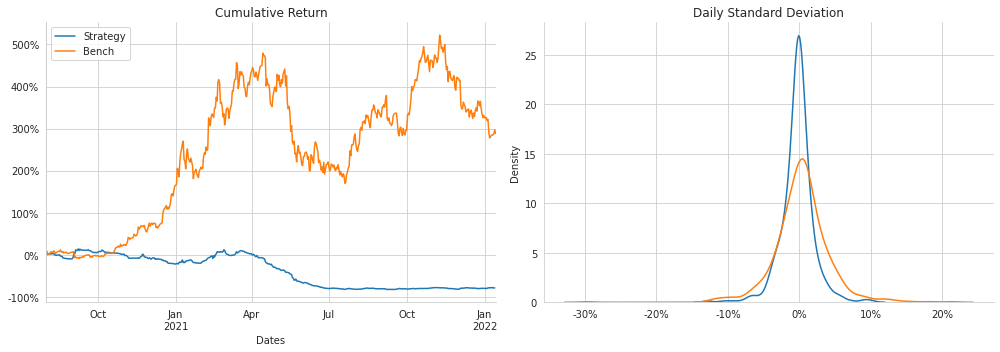

In [55]:
# Results
bench.index = pd.to_datetime(bench.index)
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy.join(bench).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(bench, ax=axes[1], hist=False, label='BTC')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
sns.despine()
fig.tight_layout();

In [28]:
# EVENT-DRIVEN BACKTEST with Backtestester